# Create MSS coastal DEM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask.array as da
import geopandas as gpd
import numpy as np
import pandas as pd
import pyinterp.backends.xarray as pbx
import regionmask
import rioxarray
import xarray as xr
from dask_gateway import GatewayCluster
from shapely.geometry import box
from sliiders import settings as sset
from sliiders import spatial
from sliiders.dask import upload_sliiders
from sliiders.io import open_dataarray, open_zarr, save

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
N_WORKERS = 500
N_PIXELS_PER_TILE = 3601

AUTHOR = "Ian Bolliger"
CONTACT = "ian.bolliger@blackrock.com"
DESCRIPTION = (
    "Blended DEM for coastal regions, relative to a Mean Sea Level DEM (1993-2012)"
)
METHOD = "CoastalDEM2.1 is the primary data source. Areas marked as missing or as water in CoastalDEM are infilled with SRTM15+ v2.4. AVISO MDT+ is used to convert from the orthometric datum to a MSL datum. Note: CoastalDEM uses 1/3601 degrees rather than 1/3600 (1 arc-second)."
HISTORY = """version 2.1: Associated with CoastalDEM 2.1 and SRTM15+ v2.4
version 2.1.1: Updated pixel source data to define SRTM15+ ocean vs. inland pixels. Dropped datum transformation from EGM96 to XGM2019_e b/c unsure of whether there is some smoothing done to SRTM specific to EGM that, upon transformation, would result in some spatial noise. Updated list of tiles to drop tiles that will wind up having elevations too high to matter for coastal regions and to include potentially-inland CoastalDEM tiles b/c we now will filter these later based on hydraulic connectivity. Added int_res field to denote pixels that had integer resolution (i.e. from SRTM15+) such that later on we can smooth the exposure in these pixels over a 1m distribution."""

OUT_ATTRS = {
    "z": {"units": "m", "long_name": "elevation relative to MSL 1993-2012"},
    "source": {
        "long_name": "data source",
        "description": """0: CoastalDEM
1: CoastalDEM water pixels replaced with SRTM15+
2: CoastalDEM missing or out-of-range pixels infilled with SRTM15+
3: Non-CoastalDEM tile (SRTM15+) ocean pixel
4: Non-CoastalDEM tile (SRTM15+) inland pixel""",
    },
    "int_res": {
        "long_name": "Integer resolution flag",
        "description": "True for pixels that have integer elevation resolution.",
    },
}

In [4]:
cluster = GatewayCluster(profile="micro", idle_timeout=1800)
client = cluster.get_client()
upload_sliiders(client)
cluster.adapt(minimum=7, maximum=100)
cluster

Define elevation-processing functions

In [9]:
def get_grid_at_tile(da, grid_in):
    """
    Get interpolated datum tile in the same shape as `da` using `pbx.Grid2D`
    """
    buffer = 0.2

    grid = grid_in.copy()

    # Ensure tiles along the 180 meridian have coordinates defined contiguously
    if da.x[-1].item() > 179:
        new_lons = grid.lon.values
        new_lons[new_lons < -179] = new_lons[new_lons < -179] + 360
        grid = grid.assign_coords({"lon": new_lons})
    elif da.x[0].item() < -179:
        new_lons = grid.lon.values
        new_lons[new_lons > 179] = new_lons[new_lons > 179] - 360
        grid = grid.assign_coords({"lon": new_lons})

    grid = grid.isel(
        lon=(grid.lon >= da.x.min().item() - buffer)
        & (grid.lon <= da.x.max().item() + buffer),
        lat=(grid.lat >= da.y.min().item() - buffer)
        & (grid.lat <= da.y.max().item() + buffer),
    ).load()

    grid = grid.sortby("lon")

    grid.lon.attrs["units"] = "degrees_east"
    grid.lat.attrs["units"] = "degrees_north"

    interpolator = pbx.Grid2D(grid, geodetic=True)

    mx, my = np.meshgrid(da.x.values, da.y.values, indexing="ij")

    out = interpolator.bicubic(dict(lon=mx.flatten(), lat=my.flatten()))

    out = out.reshape(mx.shape)
    out = xr.DataArray(out).rename({"dim_0": "x", "dim_1": "y"})
    out["x"] = da.x.values
    out["y"] = da.y.values

    return out


def get_tile_path(tile, fuse=False):
    """Get raw CoastalDEM tile path"""
    out = sset.DIR_COASTALDEM / f"{tile}.tif"
    if fuse:
        out = str(out).replace("gs:/", "/gcs")
    return out


def get_lonlat_range(lon_min, lat_min, lon_max, lat_max):
    return np.arange(
        lon_min + 0.5 / N_PIXELS_PER_TILE, lon_max, 1 / N_PIXELS_PER_TILE
    ), np.arange(lat_min + 0.5 / N_PIXELS_PER_TILE, lat_max, 1 / N_PIXELS_PER_TILE)


def get_elev_tile(
    tile_name,
):
    """
    Get 1-arcsec elevation tile relative to MSS.
    Use CoastalDEM where available, replacing null areas with SRTM15+.
    Get elevations relative to MSS datum using EGM96 -> XGM2019e and Mean Dynamic
        Topography (MDT) datum transformations.
    """
    llon, llat = spatial.get_ll(tile_name)
    elev_tile = (
        open_zarr(sset.PATH_ELEV_MSS, chunks=None)
        .sel(lon=slice(llon, llon + 1), lat=slice(llat, llat + 1))
        .load()
    )

    elev_tile = (
        elev_tile.z.where((elev_tile.z > 0) & (elev_tile.connected < 201))
        .to_series()
        .dropna()
    )

    z_ix = spatial.grid_val_to_ix(elev_tile, 0.1)
    return z_ix.groupby(z_ix).count()


def process_tile(
    tile_name,
    mdt=None,
    ocean_geom=None,
    check=True,
):

    # # get coastalDEM tile, filled with SRTM, relative to MSS
    # tile_path = get_tile_path(tile_name)
    # if not tile_path.is_file():
    #     return None

    return get_elev_tile(
        tile_name,
    )

Get list of tiles to process

In [6]:
coastal_tiles = pd.read_parquet(
    sset.PATH_EXPOSURE_TILE_LIST,
    filters=[("PROCESSING_SET", "in", ["CIAM", "WITHELEV"])],
).index.values
len(coastal_tiles)

8926

Run on workers

In [10]:
fut = client.map(
    process_tile,
    coastal_tiles,
    batch_size=1000,
)

In [37]:
[f for f in fut if f.status == "error"][0].result()

AttributeError: 'function' object has no attribute 'dropna'

In [11]:
res3 = [f for f in client.gather(fut) if f is not None]
alldf3 = pd.concat(res3)

In [10]:
alldf = pd.concat(res)

<AxesSubplot:>

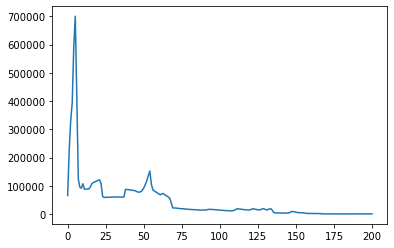

In [ ]:
fut[2436].result().sort_index().loc[:200].plot()

<AxesSubplot:xlabel='z'>

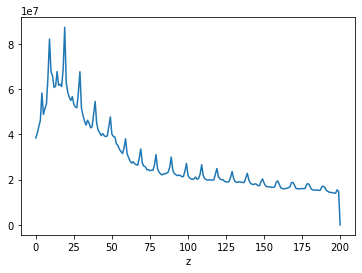

In [ ]:
alldf3.groupby(alldf3.index).sum().loc[:200].plot()

<AxesSubplot:xlabel='z'>

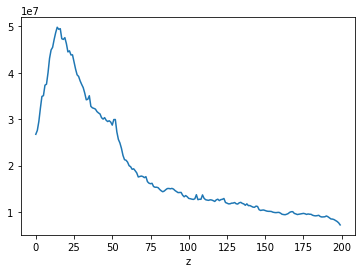

In [51]:
alldf2.groupby(alldf2.index).sum().loc[:200].plot()

<AxesSubplot:>

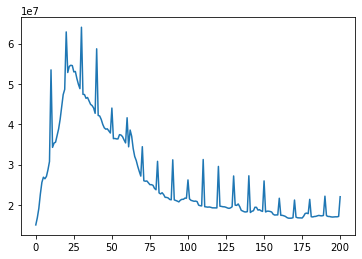

In [15]:
alldf.groupby(alldf.index).sum().loc[:200].plot()

Close cluster

In [14]:
finished = False
client.gather(fut)
finished = True

In [13]:
cluster.close()
client.close()